# Sensing for Autonomous Vehicles

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S63_driving_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import plotly.express as px
try:
    import google.colab
    # Load LIDAR scans from Github:
    !wget -q https://github.com/gtbook/robotics/raw/main/Figures6/lidar/PC_315967795019746000.ply
    !wget -q https://github.com/gtbook/robotics/raw/main/Figures6/lidar/PC_315967795520065000.ply
    !wget -q https://github.com/gtbook/robotics/raw/main/Figures6/lidar/PC_315967795919523000.ply
    !mkdir -p Figures6/lidar
    !mv *.ply Figures6/lidar/
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook import driving

```{index} sensing; LIDAR
```

> LIDAR, a sensor found in most autonomous cars, can be used to construct a 3D representation of the robot's environment in real time.

<img src="Figures6/S63-Autonomous_Vehicle_with_LIDAR_and_cameras-07.jpg"  alt="Splash image with steampunk autonomous car" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

## LIDAR

```{index} pair: LIDAR; LIght raDAR
```
```{index} Time of Flight, ToF, direct ToF, Indirect ToF
```
LIDAR (LIght raDAR) is a technology that measures distance to an object by using laser light and the **Time of Flight** or **ToF** principle. There are several variants in use, and the simplest to explain is the **direct ToF** sensor, which sends out a short pulse and measures the elapsed time $\Delta t$ for the light to bounce off an object and return to a detector collocated with the laser pulse emitter. If the object is situated at a distance $d$ from the emitter-detector pair, we have
\begin{equation}
\Delta t = \frac{2 d}{c} 
\end{equation}
where $c\approx300,000km/s$ is the speed of light. For example, for an object at 15m, we have 
\begin{equation}
\Delta t \approx \frac{2 \times 0.015}{300,000} = 0.1\mu s
\end{equation}
Assuming we can measure $\Delta t$ accurately, we can then easily compute the distance:
\begin{equation}
d= c\frac{\Delta t}{2}
\end{equation}
In a *scanning LIDAR*, there is typically one detector, whereas in a *flash LIDAR* a single pulse is emitted in a wide field of view, and an *array* of detectors, akin to a CCD sensor, is used to detect the returning light pulses in multiple directions at once.

In practice, *indirect* time of flight sensors are more prevalent in robotics and autonomous driving applications than direct ToF sensors. There are multiple reasons for this: measuring elapsed times at the nano-second scale is difficult and expensive, and the amount of light energy that needs to be emitted for direct ToF can also be a problem from an eye-safety perspective.
**Indirect ToF** is an attractive alternative, where the light is emitted as a waveform, e.g., a sine wave, and the returned light is correlated with the amplitude of the emitted light to calculate a phase shift. The elapsed time $\Delta t$ and distance $d$ can then be calculated from the phase shift.

```{index} 2D LIDAR, 3D LIDAR
```
Two common scanning LIDAR technologies are in use for robotics: **2D LIDAR**, which consists of a single laser beam that is rotated around a fixed axis, and **3D LIDAR**, which has multiple laser/detector pairs rotated at different inclinations. 2D LIDAR is also often deployed on aircraft to create highly detailed digital elevation maps, where the third dimension is provided by the aircraft's forward motion. LIDAR altimeters are even deployed from satellites in orbit around Earth or [other planets](https://pgda.gsfc.nasa.gov/products/62).

```{index} ray direction
```
## Ray Intersection

> Intersecting rays is as easy as computing a dot product.

To perform inference about the environment using LIDAR, we have to model how LIDAR beams interact with the environment, which in the case of polygonal objects comes down to line-line or line-plane intersections.

We examine the 2D line-line intersection case first. Assume we have a line in 2D with equation $\hat{n} \cdot p = d$, where $\hat{n}$ is a normal vector and $d>0$ is the distance of the line to the origin. The hat notation signifies that the normal vector $\hat{n}$ is normalized to length 1. Then if we have a ray of points $p = \hat{r} s$ where $\hat{r}$ is the **ray direction** and $s>0$ is a scalar, we can find the intersection by plugging the ray equation into the line equation
\begin{equation}
\hat{n} \cdot (\hat{r} s) = d,
\end{equation}
where $a \cdot b \doteq a^T b = b^T a$ is the standard vector dot product. We find the range $s$ to the object as:
\begin{equation}
s = \frac{d}{\hat{n} \cdot \hat{r}}.
\end{equation}
We can ensure that $s>0$ and avoid a division by zero by checking the dot product before doing the division:
\begin{equation}
\hat{n} \cdot \hat{r} > 0
\end{equation}
The following code implements this:

In [3]:
def intersect(n, d, ray):
    """Intersect line/plane (n,d) with ray given by direction r."""
    cos = np.dot(n,ray)
    return d / cos if cos>0 else float('nan')

assert intersect(n=gtsam.Point2(1,0), d=5, ray=gtsam.Point2(1,0)) == 5

{raw:tex}`\noindent`
The story above generalizes *completely* to 3D, where with $\hat{n}\in\mathbb{R}^3$ and $p\in\mathbb{R}^3$.
In this case, the equation $\hat{n} \cdot p = d$ defines a *plane* in 3D:

In [4]:
assert intersect(n=gtsam.Point3(1,0,0), d=5, ray=gtsam.Point3(1,0,0)) == 5

## Simulating a 2D LIDAR

> Computing line intersections is the main computation when simulating 2D LIDAR.

We now put the above to work to simulate a 2D LIDAR sensor situated at the origin. The *SICK Tim1xx* is a relatively low-cost 2D LIDAR sensor, which has a field of view of 200 degrees and a resolution of one beam per degree. Hence, we expect to simulate 200 measurements.

In our simple simulation code below, we create an environment from infinite lines. A more powerful simulator would allow for line *segments*, but infinite lines are enough to illustrate the principle. We create a corridor-like environment with three sides:

In [5]:
north = gtsam.Point2(0,1), 2.5
east = gtsam.Point2(1,0), 8
south = gtsam.Point2(0,-1), 2.5

{raw:tex}`\noindent`
Then, in Figure [1](#fig:lidar_rays_200) we create 200 unit vectors that will correspond to 200 simulated rays. We create them at uniformly spaces angles ranging from -100 degrees to 100 degrees, with 0 facing due East in the Figure.

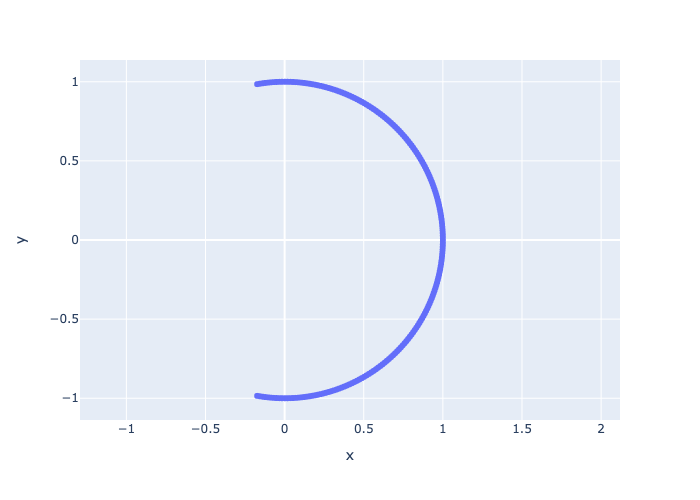

In [6]:
#| caption: 200 unit vectors corresponding to LIDAR rays at different angles.
#| label: fig:lidar_rays_200
angles = np.linspace(-100, 100, 200)
rays = np.array([gtsam.Rot2(math.radians(angle)).matrix()[0,:] for angle in angles])
fig = px.scatter(x=rays[:,0],y=rays[:,1])
fig.update_yaxes(scaleanchor = "x", scaleratio = 1); fig.show()

Finally, we compute the intersection with the simulated corridor-like environment in Figure [2](#fig:lidar_scan_200), using the `intersect` function we defined earlier. Note the "environment" is just a a list of lines represented as $(\hat n,d)$ pairs.

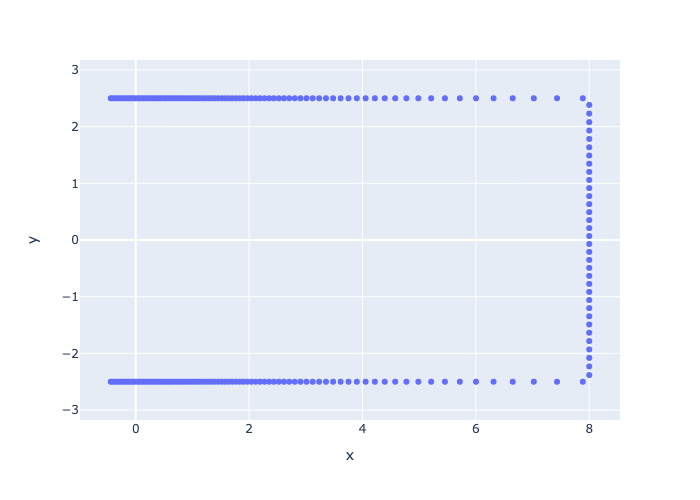

In [7]:
#| caption: A simulated scan by intersecting 200 rays with the environment.
#| label: fig:lidar_scan_200
scan = []
for ray in rays:
    ranges = [intersect(n,d,ray) for n, d in [north, east, south]]
    _range = np.nanmin(ranges)
    intersection = _range * ray
    scan.append(intersection)
scan_x, scan_y = zip(*scan)
fig = px.scatter(x=scan_x, y=scan_y)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1); fig.show()

As you can see, the resulting scan of this corridor-like environment does not produce a uniform sampling on the walls. Because the rays are distributed uniformly in *angle* space, they graze the walls at increasingly shallow angles, and the distance between successive intersection points increases. Of course, this depends on the angle that the wall makes with the rays: the end of the corridor is far away and hence is sampled fairly uniformly. This is a typical pattern when working with LIDAR scanners.

## Geometry of a Moving LIDAR

Above we assumed that the ray is situated at the *world* origin, but we can also generalize to the case where the rays are defined in a *body coordinate frame* $(R^w_b,t^w_b)$.
In this case, it is convenient to transform the plane to the body frame. We can do this by expressing a point $p^w$ in world coordinates as a function of a point in body coordinates, $p^w = R^w_b p^b + t^w_b$, and plugging that into the plane equation:
\begin{equation}
\begin{aligned}
\hat{n}^w \cdot p^w &= d^w \\
\hat{n}^w \cdot \{ R^w_b p^b + t^w_b \} &= d^w \\
\hat{n}^w \cdot R^w_b p^b + \hat{n}^w \cdot t^w_b &= d^w \\
(R^w_b)^T \hat{n}^w \cdot p^b &= d^w - \hat{n}^w \cdot t^w_b.
\end{aligned}
\end{equation}
where in the last line we made use of $a \cdot R b = R^T a \cdot b$.
Hence, we obtain a new plane equation *in the body frame* as
\begin{equation}
\hat{n}^b \cdot p^b = d^b
\end{equation}
with transformed plane parameters $\hat{n}^b \doteq (R^w_b)^T \hat{n}^w$ and $d^b \doteq d^w - \hat{n}^w \cdot t^w_b$.

We can use a `Pose2` or `Pose3` object to specify the body frame, respectively in 2D or 3D, and then use it to transform plane coordinates:

In [8]:
def transform_to(n, d, wTb):
    """Transform line/plane (n,d) to body coordinate frame"""
    wRb = wTb.rotation()
    wtb = wTb.translation()
    return wRb.matrix().T @ n, d - np.dot(n, wtb)

{raw:tex}`\noindent`
We can do this for lines in 2D

In [9]:
wTb = gtsam.Pose2(r=gtsam.Rot2(math.radians(20)), t=[2,1])
print(transform_to(gtsam.Point2(1,0), 5, wTb))

(array([ 0.93969262, -0.34202014]), 3.0)


{raw:tex}`\noindent`
and for planes in 3D:

In [10]:
wTb3 = gtsam.Pose3(r=gtsam.Rot3.Yaw(math.radians(45)), t=[1,2,3])
print(transform_to(gtsam.Point3(1,0,0), 5, wTb3))

(array([ 0.70710678, -0.70710678,  0.        ]), 4.0)


With this new functionality we can transform the world model and predict what the scan will look like, in body coordinates, as shown in Figure [3](#fig:lidar_scan_200_2).

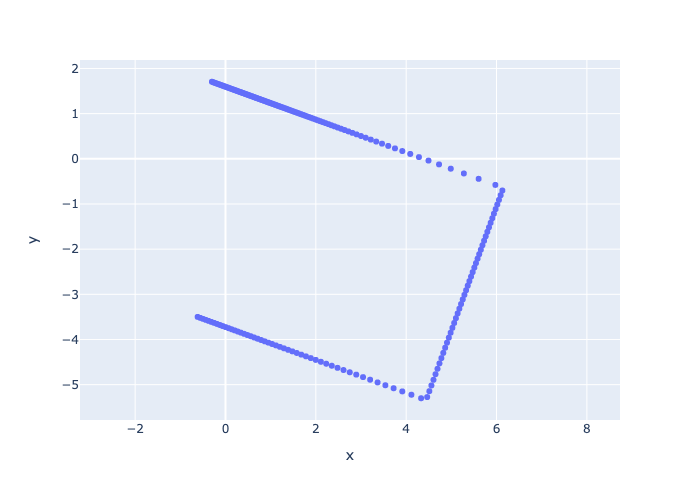

In [11]:
#| caption: Simulated scan from a different location in the same environment.
#| label: fig:lidar_scan_200_2
scan2 = []
transformed = [transform_to(n, d, wTb) for n, d in [north, east, south]]
for ray in rays:
    ranges = [intersect(n,d,ray) for n, d in transformed]
    _range = np.nanmin(ranges)
    intersection = _range * ray
    scan2.append(intersection)
scan2_x, scan2_y = zip(*scan2)
fig = px.scatter(x=scan2_x, y=scan2_y)
fig.update_yaxes(scaleanchor = "x", scaleratio = 1); fig.show()

As you can see above, when the robot rotates 20 degrees *counter-clockwise*, the resulting scan in body coordinates seems to be rotated 20 degrees in the *opposite* direction. This makes sense! The forward direction for the robot is along the horizontal x-axis, and as you can see in the scan, the robot seems to be "looking" at the correct (upper-right) corner of our little hallway example. This perhaps counter-intuitive behavior is something to always keep in mind when looking at animations of LIDAR scans.

## Real LIDAR Scans

> From theory to practice.

3D LIDAR sensors have been used in many autonomous driving efforts, e.g., by Waymo, Cruise, Argo, etc. Below we explore some real scans from the [Argoverse 2 Lidar Dataset](https://www.argoverse.org/av2.html) {cite:p}`Wilson21_Argoverse2`.

First, let us look at a single scan, shown in Figure [4](#fig:lidar_scan_real), which was acquired using a [Velodyne](https://velodynelidar.com/products/ultra-puck/) VLP-32C LIDAR sensor. 
The `32` in the model name reflects the fact that, for this particular sensor, there are 32 separate laser beams at different inclinations, that spin around for a full 360 degree field of view. In this case, the inclination angles are uniformly sampled between -25 and +15 degrees with respect to horizontal, but of course this depends on the application/sensor model.

Several things worth noting when looking at the single scan below, taken when the Argo test car is turning at an intersection:
- The location of the car (at the origin) is marked by concentric circles formed by the lowest beams.
- The range is approximately 200m, so we can see fairly far down the cross streets.
- Occlusion is significant: objects close to the car throw "occlusion shadows."
- Everything is in *body coordinates*, and the streets appear rotated because the car is actually turning.

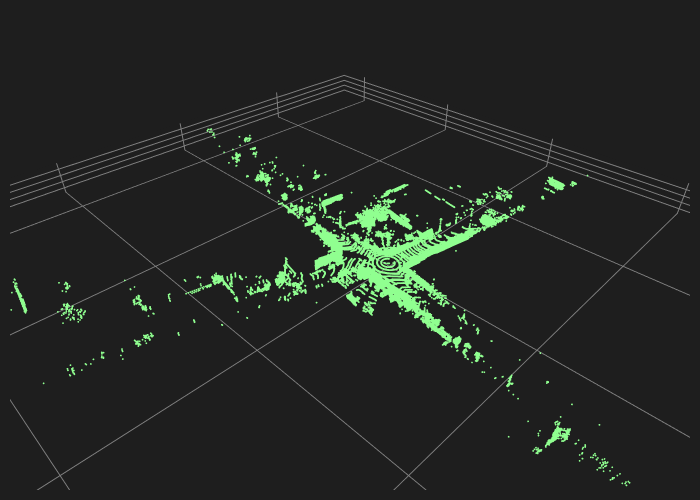

In [12]:
#| caption: An actual 3D Velodyne LIDAR scan from an autonomous vehicle.
#| label: fig:lidar_scan_real
real_scans = {0:driving.read_lidar_points('Figures6/lidar/PC_315967795019746000.ply')}
driving.visualize_cloud(real_scans[0], show_grid_lines=True)

We can also learn some things from looking at two successive scans in Figure [5](#fig:lidar_scan_real_2). 
The scans are slightly rotated and translated from each other,
and this will be exactly how we can infer the motion of the car in the next section.

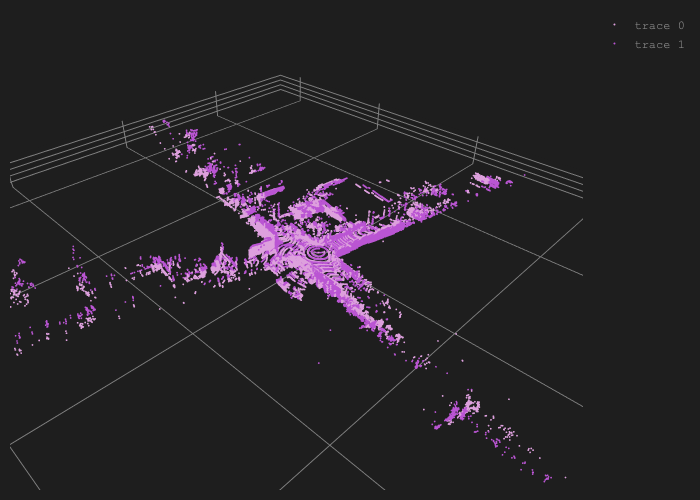

In [13]:
#| caption: Two successive LIDAR scans from an autonomous vehicle.
#| label: fig:lidar_scan_real_2
real_scans[1] = driving.read_lidar_points('Figures6/lidar/PC_315967795520065000.ply')
driving.visualize_clouds([real_scans[0],real_scans[1]], show_grid_lines=True)

Finally, let us look - in Figure [6](#fig:lidar_scan_real_8) - at scans that are taken a bit further apart, in this case there are 8 scans that we skipped.

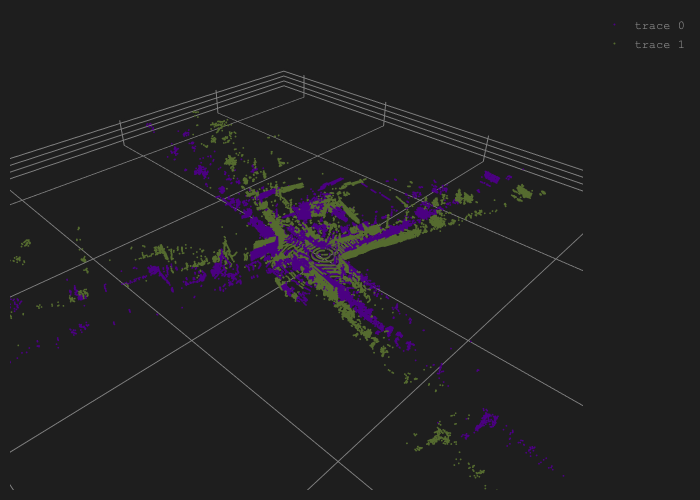

In [14]:
#| caption: Two LIDAR scans from an autonomous vehicle that are eight frames apart.
#| label: fig:lidar_scan_real_8
real_scans[9] = driving.read_lidar_points('Figures6/lidar/PC_315967795919523000.ply')
driving.visualize_clouds([real_scans[0],real_scans[9]], show_grid_lines=True)

By inspecting (you can do this interactively using the [gtbook website](https://gtbook.github.io/gtbook/driving.html)) you can see that the car is *still* turning, but as the two scans are further apart the "mis-alginment" is more pronounced.

## Creating 3D Maps

> Point clouds can be used to represent the 3D world.

```{index} point cloud map
```
If we know the exact pose at which a LIDAR scan was taken, we can transform the points in the scan into absolute coordinates, and create an extended **point cloud map** of the environment. In math, suppose we *know* that a scan was taken at $T^w_b$, then we can transform all LIDAR points $P^b$, which are given in body coordinates, to world coordinates:
\begin{equation}
P^w = \phi(T^w_b, P^b)
\end{equation}
where $\phi$ the action of $SE(3)$ on points in $\mathbb{R}^3$. Earlier in this chapter we saw this can be done by matrix multiplication, but GTSAM actually implements $\phi$ directly as `Pose3::transformFrom`. This method can be applied to a single `Point3` (just a $3\times 1$ vector, really) or on many points simultaneously, by passing in a $3\times N$ matrix:

In [15]:
scan_in_world = wTb3.transformFrom(real_scans[0])
print(scan_in_world.shape)

(3, 86651)


We will use this capability in the next section to produce large scale sparse point cloud maps of the environment around an autonomous vehicle.

## GTSAM 101

> A deeper dive in the GTSAM concepts used above.

### 2D and 3D Points

In GTSAM `Point2` and `Point3` are simply functions that return 2D and 3D numpy vectors, respectively:

In [16]:
p = gtsam.Point2(3,4)
P = gtsam.Point3(5,6,7)
print(type(p), p)
print(type(P), P)

<class 'numpy.ndarray'> [3. 4.]
<class 'numpy.ndarray'> [5. 6. 7.]


### 2D and 3D Rotations

2D and 3D rotations are represented internally by $2 \times 2$ matrices and $3 \times 3$ matrices, respectively, but these are wrapped into the classes `Rot2` and `Rot3`. We can print them, and get the rotation matrix via the `matrix()` method:

In [17]:
R1 = gtsam.Rot2(20 * math.pi / 180) # 20 degrees rotation
print(R1, R1.matrix())

theta: 0.349066
 [[ 0.93969262 -0.34202014]
 [ 0.34202014  0.93969262]]


In [18]:
R2 = gtsam.Rot3()
print(R2, R2.matrix())

R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


While there are various methods to create 3D rotation matrices (use help!), above we only use the named constructor `Yaw` , which is a rotation around the z-axis. Below is an example, which you can compare with the 2D rotation example above.

In [19]:
R3 = gtsam.Rot3.Yaw(20 * math.pi / 180) # 20 degrees rotation around Z
print(R3, R3.matrix())

R: [
	0.939693, -0.34202, 0;
	0.34202, 0.939693, 0;
	0, 0, 1
]
 [[ 0.93969262 -0.34202014  0.        ]
 [ 0.34202014  0.93969262  0.        ]
 [ 0.          0.          1.        ]]


We will look at 3D rotations in much more detail in Chapter 7, when we look at drones.

### Reading and Visualizing LIDAR clouds

The utility functions `read_lidar_points` and `visualize_clouds` are not part of GTSAM, but are part of the gtbook library that accompanies this book. On the [gtbook website](https://gtbook.github.io/gtbook/driving.html) {cite:p}`gtbook` you can find much more detailed documentation as well as the source code, but `help` is very comprehensive for those functions. While the visualization code is statically rendered in the book, when you open the Colab things should be rendered as interactive `plotly` scatter plots. Try it!